In [1]:
import os
import sys
import random
#import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
import uproot 
import time
from training_func import*
from matplotlib.colors import LogNorm


In [2]:
NEvent = 10000
PATH_FILE='/home/santilor/GPU_SupRes/PFlowNtupleFile_HOMDet_2to5GeV_Overlap_WS.root'
n_epochs = 200
NAME = "_SupRes_2L"
PATH_NN='model_NN'+str(NAME)+'.pt'


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch import tensor
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [4]:
f = uproot.open(PATH_FILE)

In [5]:
f['EventTree'].keys()

[b'new_v',
 b'Cell_E',
 b'Total_Ch_Energy',
 b'Total_Nu_Energy',
 b'True_Ch_Energy',
 b'True_Nu_Energy',
 b'Smeared_Ch_Energy',
 b'Trk_X_indx',
 b'Trk_Y_indx',
 b'Trk_X_pos',
 b'Trk_Y_pos',
 b'Trk_Theta',
 b'Trk_Phi',
 b'Pi0_X_pos',
 b'Pi0_Y_pos',
 b'Pi0_Theta',
 b'Pi0_Phi',
 b'Photon1_E',
 b'Photon2_E',
 b'Photon1_Theta',
 b'Photon2_Theta',
 b'Photon1_Phi',
 b'Photon2_Phi',
 b'cell_Energy',
 b'cellCh_Energy',
 b'cellNu_Energy',
 b'Noise_cell_Energy']

In [6]:
true_pix, orig_pix, det_size = 128, 64, 125.
LayerPix = np.array([64, 16])
supL=np.array([64, 64])
No_Lay=np.array([13,34])

In [7]:
print("Read TTree - ", NEvent)


Read TTree -  10000


In [9]:
### --- Import CH ---###
start = time.time()
Ch_Layer_Orig = [f['EventTree'].array('cellCh_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0,int(NEvent/1000)  )] 
Ch_Layer_Orig = np.stack(Ch_Layer_Orig, axis=0)[:, :, :2]
Ch_Layer_Orig = Ch_Layer_Orig.reshape(NEvent, 2, true_pix, true_pix)
end = time.time()
print(end-start, "Ch import")

5.910912275314331 Ch import


In [10]:
### --- Import NU ---###
start = time.time()
Nu_Layer_Orig = [f['EventTree'].array('cellNu_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0,int(NEvent/1000)  )] 
Nu_Layer_Orig = np.stack(Nu_Layer_Orig, axis=0)
Nu_Layer_Orig = Nu_Layer_Orig.reshape(NEvent, 6, true_pix, true_pix)
end = time.time()
print(end-start, "Nu import")

5.570043325424194 Nu import


In [11]:
### --- Import TRK ---###
start = time.time()
Trk_X_pos = [f['EventTree'].array('Trk_X_pos', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0, int(NEvent/1000)  )]
Trk_Y_pos = [f['EventTree'].array('Trk_Y_pos', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0, int(NEvent/1000)  )]
Trk_X_pos = np.stack(Trk_X_pos, axis=0)
Trk_X_pos = Trk_X_pos.reshape(NEvent, )
Trk_Y_pos = np.stack(Trk_Y_pos, axis=0)
Trk_Y_pos = Trk_Y_pos.reshape(NEvent, )

Trk_X_pos/=10.
Trk_Y_pos/=10.

end = time.time()
print(end-start, "TRK import")

0.9338631629943848 TRK import


In [12]:
### --- Import PT ---###
start = time.time()
Track_Energy = [f['EventTree'].array('Smeared_Ch_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0,  int(NEvent/1000)  )]
Track_Energy = np.stack(Track_Energy, axis=0)
Track_Energy = Track_Energy.reshape(NEvent, )
end = time.time()
print(end-start, "PT import")

0.46407222747802734 PT import


In [13]:
### --- MAKE ORIG RESOLUTION : [64,64]--- ###
start = time.time()
Ch_ori=np.asarray([ [SumPixel(Ch_Layer_Orig[ev][i], orig_pix) for i in range(2)] for ev in range(NEvent)])
Nu_ori=np.asarray([ [SumPixel(Nu_Layer_Orig[ev][i], orig_pix) for i in range(2)] for ev in range(NEvent)])
end = time.time()
print(end-start, "Make Orig Res")

615.4288306236267 Make Orig Res


In [13]:
del Ch_Layer_Orig
del Nu_Layer_Orig

In [14]:
### --- SMEAR ORIG RESOLUTION : [64,64]--- ###
#start = time.time()
#Ch_ori=np.asarray([[SmearImage(Ch_ori[ev][i][:orig_pix,:orig_pix]) for i in range(2)] for ev in range(NEvent) ])
#Nu_ori=np.asarray([[SmearImage(Nu_ori[ev][i][:orig_pix,:orig_pix]) for i in range(2)] for ev in range(NEvent) ])
#end = time.time()
#print(end-start, "Smear Orig Res")
#print(Ch_ori.shape)

In [15]:
### --- MAKE SUP RESOLUTION : [64,64]--- ###
start = time.time()
Ch_sup=np.asarray([ [SumPixel(Ch_ori[ev][i], supL[i]) for i in range(2)] for ev in range(NEvent)])
Nu_sup=np.asarray([ [SumPixel(Nu_ori[ev][i], supL[i]) for i in range(2)] for ev in range(NEvent)])
end = time.time()
print(end-start, "Make Sup Res")
print(Ch_sup.shape)

0.24700713157653809 Make Sup Res
(10000, 2, 64, 64)


In [16]:
del Ch_ori
del Nu_ori

In [16]:
### --- MAKE SUP RES TARGET NU AND CH : [64,64] --- ###
targ_ch = [np.zeros((1000,2,orig_pix,orig_pix)) for i in range(0, int(NEvent/1000) )]
targ_ch = np.stack(targ_ch, axis=0)
targ_ch = targ_ch.reshape(NEvent, 2, orig_pix, orig_pix)
for l in range(2):
    targ_ch[:,l,:supL[l],:supL[l]] = Ch_sup[:,l]
    #targ_ch[:,l][np.where(targ_ch[:,l]<0.)]=0.

    
targ_nu = [np.zeros((1000,2,orig_pix,orig_pix)) for i in range(0, int(NEvent/1000) )]
targ_nu = np.stack(targ_nu, axis=0)
targ_nu = targ_nu.reshape(NEvent, 2, orig_pix, orig_pix)
targ_nu = Nu_sup
for l in range(2):
    targ_nu[:,l,:supL[l],:supL[l]] = Nu_sup[:,l]
    #targ_nu[:,l][np.where(targ_nu[:,l]<0.)]=0.


In [17]:
### --- MAKE REAL RESOLUTION : [64,16] --- ###
start = time.time()
Ch_real=np.asarray([ [SumPixel(Ch_sup[ev][i], LayerPix[i]) for i in range(2)] for ev in range(NEvent)])
Nu_real=np.asarray([ [SumPixel(Nu_sup[ev][i], LayerPix[i]) for i in range(2)] for ev in range(NEvent)])
end = time.time()
print(end-start, "Make Real Res")
print(Ch_real.shape)

20.394970893859863 Make Real Res
(10000, 2)


In [19]:
del Ch_sup
del Nu_sup


In [18]:
### --- MAKE INPUT LAYER REAL RES : Tot + Trk [64,16;64] as [64,64,64]--- ###

input_Layer = [np.zeros((1000,3,orig_pix,orig_pix)) for i in range(0, int(NEvent/1000) )]
input_Layer = np.stack(input_Layer, axis=0)
input_Layer = input_Layer.reshape(NEvent, 3, orig_pix, orig_pix)
for ev in range(NEvent):
    for i in range(2):
        input_Layer[ev][i][:LayerPix[i],:LayerPix[i]]=Ch_real[ev][i]+Nu_real[ev][i]
        #input_Layer[ev][i][np.where(input_Layer[ev][i]<0.)]=0.
    input_Layer[ev][-1]=MakeTrackLayer(Track_Energy[ev],Trk_X_pos[ev],Trk_Y_pos[ev])

In [21]:
del Track_Energy
del Trk_X_pos
del Trk_Y_pos

In [22]:
del Ch_real
del Nu_real

In [23]:
#targ_Layer = [np.zeros((1000,2,orig_pix,orig_pix)) for i in range(0, int(NEvent/1000) )]
#targ_Layer = np.stack(targ_Layer, axis=0)
#targ_Layer = targ_Layer.reshape(NEvent, 2, orig_pix, orig_pix)

#for ev in range(NEvent):
#    for i in range(2):
#        targ_Layer[ev][i][:LayerPix[i],:LayerPix[i]]=Nu_real[ev][i]/(Ch_real[ev][i]+Nu_real[ev][i])
#        targ_Layer[ev][i][np.where(targ_Layer[ev][i]<0.)]=0
#        targ_Layer[ev][i][np.where(targ_Layer[ev][i]>1.)]=1
#        targ_Layer[ev][i][np.where(np.isnan(targ_Layer[ev][i]))]=0
#        targ_Layer[ev][i][np.where(np.isinf(targ_Layer[ev][i]))]=0


In [19]:
#input shape
print("in shape",input_Layer.shape)
#target shape
print("tar shape",targ_ch.shape)

in shape (10000, 3, 64, 64)
tar shape (10000, 2, 64, 64)


[64 16]


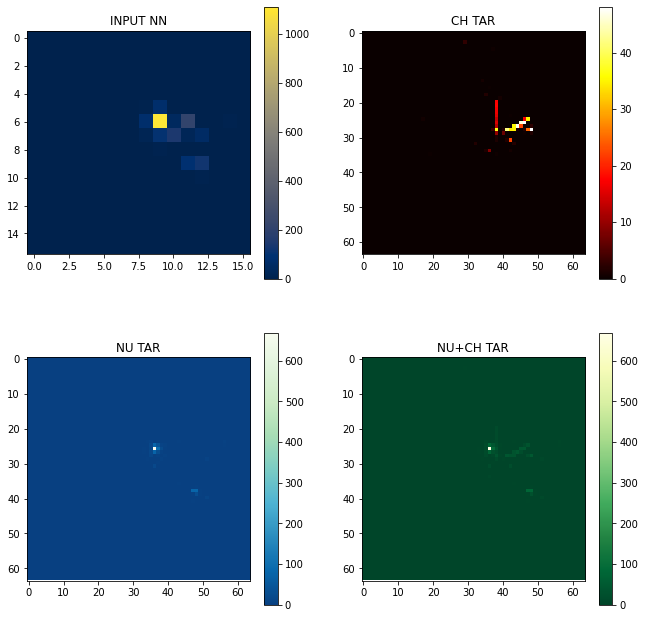

In [21]:
ev, l = 23, 1
print(LayerPix)
plt.figure(figsize=(11, 11))

plt.subplot(221)
plt.title("INPUT NN")
plt.imshow(input_Layer[ev][l][:LayerPix[l],:LayerPix[l]].T, cmap = "cividis")
plt.colorbar()

plt.subplot(222)
plt.title("CH TAR")
plt.imshow(targ_ch[ev][l].T, cmap="hot")
plt.colorbar()

plt.subplot(223)
plt.title("NU TAR")
plt.imshow(targ_nu[ev][l].T, cmap="GnBu_r")
plt.colorbar()

plt.subplot(224)
plt.title("NU+CH TAR")
plt.imshow(targ_nu[ev][l].T+targ_ch[ev][l].T, cmap="YlGn_r")
plt.colorbar()

plt.show()

In [22]:
train_size, val_size = int(0.8 * NEvent), int(0.2 * NEvent)
test_size = NEvent - (train_size + val_size)
indices = list(range(NEvent))
np.random.shuffle(indices)

In [23]:
input_Layer = input_Layer[indices]
targ_ch     = targ_ch[indices]
targ_nu     = targ_nu[indices]

#target_Layer = target_Layer[indices]

train_Layer, val_Layer = input_Layer[0:train_size], input_Layer[train_size: train_size + val_size]
train_ch, val_ch       =     targ_ch[0:train_size],     targ_ch[train_size: train_size + val_size]
train_nu, val_nu       =     targ_nu[0:train_size],     targ_nu[train_size: train_size + val_size]
#train_tot, val_tot = targ_ch[0:train_size], targ_ch[train_size: train_size + val_size]

#train_SupLayer, val_SupLayer = target_Layer[0:train_size], target_Layer[train_size: train_size + val_size]



In [66]:
np.save("numpy_fil/train_Layer.npy",train_Layer)
np.save("numpy_fil/val_Layer.npy",val_Layer)
np.save("numpy_fil/train_ch.npy",train_ch)
np.save("numpy_fil/val_ch.npy",val_ch)
np.save("numpy_fil/train_nu.npy",train_nu)
np.save("numpy_fil/val_nu.npy",val_nu)


In [69]:
train_Layer1=np.load("numpy_fil/train_Layer.npy")
print(train_Layer1==train_Layer)

[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]]


 [[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  Tr

In [24]:
#del input_Layer; 
#del targ_ch;
#del targ_nu;
##del nu_frac;

In [25]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [26]:
cuda_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )


In [27]:
torch.cuda.get_device_name( torch.cuda.current_device() )



'Quadro P2000'

In [28]:
###############

#CNN 

##############

class Upconv(nn.Module):
    def __init__(self, upscale_factor):
        super(Upconv, self).__init__()

        self.prelu = nn.LeakyReLU(negative_slope=0.1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=1,padding=1) 
        self.conv4 = nn.Conv2d(64, 128,kernel_size=3,stride=1,padding=1) 
        self.conv5 = nn.Conv2d(128, 128,kernel_size=3,stride=1,padding=1)
        self.conv6 = nn.Conv2d(128, 256,kernel_size=3,stride=1,padding=1)
        #self.conv7 = nn.ConvTranspose2d(256, 1,kernel_size=4,stride=2,padding=1,bias=False)
        self.conv8 = nn.PixelShuffle(upscale_factor)
        self.convf = nn.Conv2d( int(256/upscale_factor**2), 1,kernel_size=1)

    def forward(self, x):
        x = self.bn1(self.prelu(self.conv1(x)))
        x = self.bn2(self.prelu(self.conv2(x)))
        x = self.bn3(self.prelu(self.conv3(x)))
        x = self.bn4(self.prelu(self.conv4(x)))
        x = self.bn5(self.prelu(self.conv5(x)))
        x = self.bn6(self.prelu(self.conv6(x)))
        x = self.conv8(x)
        x = self.convf(x)
        x = self.relu(x)
        
        
        return x

In [30]:
class SuperResModel(nn.Module):
    
    def __init__(self):
        super(SuperResModel, self).__init__()
        self.cnn1 = Upconv(upscale_factor = int(orig_pix/LayerPix[0]) ).float()
        self.cnn2 = Upconv(upscale_factor = int(orig_pix/LayerPix[1]) ).float()


        self.cnn_comb = nn.Conv2d(3, 4,kernel_size=1,stride=1,padding=0)
        
        self.cnn1_out_ch = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[0]),stride=int(orig_pix/supL[0]),padding=0)
        self.cnn2_out_ch = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[1]),stride=int(orig_pix/supL[1]),padding=0)
         
        self.cnn1_out_nu = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[0]),stride=int(orig_pix/supL[0]),padding=0)
        self.cnn2_out_nu = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[1]),stride=int(orig_pix/supL[1]),padding=0)
        
        #self.cnn1_out_tot = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[0]),stride=int(orig_pix/supL[0]),padding=0)
        #self.cnn2_out_tot = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[1]),stride=int(orig_pix/supL[1]),padding=0)

    def forward(self, x):
        

        out1 = self.cnn1( x[:,0:1, 0:LayerPix[0], 0:LayerPix[0]].float() )
        out2 = self.cnn2( x[:,1:2, 0:LayerPix[1], 0:LayerPix[1]].float() )
        out3 = x[:, 2:3, 0:orig_pix, 0:orig_pix].float()
        
        merged_im = torch.cat(  (out1, out2, out3), dim=1 )
        
        out_int = self.cnn_comb(merged_im)
        
        out1_f_ch = ExpandLayer(  self.cnn1_out_ch(out_int[:, 0:1, :, :])  )
        out2_f_ch = ExpandLayer(  self.cnn2_out_ch(out_int[:, 1:2, :, :])  )
        
        out1_f_nu = ExpandLayer(  self.cnn1_out_nu(out_int[:, 2:3, :, :])  )
        out2_f_nu = ExpandLayer(  self.cnn2_out_nu(out_int[:, 3:4, :, :])  )
        
        merged =  torch.cat(  (out1_f_ch, out2_f_ch, 
                               out1_f_nu, out2_f_nu), dim=1 )
        
        
        return merged

In [31]:
model = SuperResModel()
model.to(cuda_device)

SuperResModel(
  (cnn1): Upconv(
    (prelu): LeakyReLU(negative_slope=0.1)
    (relu): ReLU()
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(128, 128, kernel_siz

In [32]:
test_out = model(  Tensor(input_Layer[23:21]).cuda() )

In [33]:
print(test_out.shape)

torch.Size([1, 4, 64, 64])


[64 16]


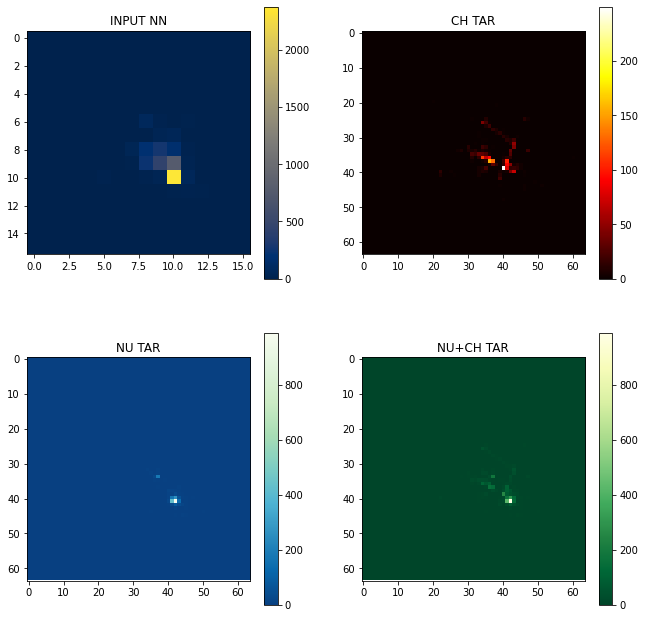

In [49]:
ev, l = 332, 1
print(LayerPix)
plt.figure(figsize=(11, 11))

plt.subplot(221)
plt.title("INPUT NN")
plt.imshow(input_Layer[ev][l][:LayerPix[l],:LayerPix[l]].T, cmap = "cividis")
plt.colorbar()

plt.subplot(222)
plt.title("CH TAR")
plt.imshow(targ_ch[ev][l].T, cmap="hot")
plt.colorbar()

plt.subplot(223)
plt.title("NU TAR")
plt.imshow(targ_nu[ev][l].T, cmap="GnBu_r")
plt.colorbar()

plt.subplot(224)
plt.title("NU+CH TAR")
plt.imshow(targ_nu[ev][l].T+targ_ch[ev][l].T, cmap="YlGn_r")
plt.colorbar()

plt.show()

In [50]:
print(train_Layer.shape)

(8000, 3, 64, 64)


In [52]:
train_dataset = TensorDataset( Tensor( torch.from_numpy(train_Layer).float() ),
                               Tensor( torch.from_numpy(  train_ch ).float() ),
                               Tensor( torch.from_numpy(  train_nu ).float() )  )
valid_dataset = TensorDataset( Tensor( torch.from_numpy(  val_Layer).float() ),
                               Tensor( torch.from_numpy( val_ch    ).float() ),
                               Tensor( torch.from_numpy( val_nu    ).float() )  )

In [53]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=20)


In [54]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
total_step = len(train_loader)
print(total_step)

400


In [55]:
###---- LOSS FUNCTION OF CNN ----###
def LossFunction(pred,tar_ch ,tar_nu ) : 
    pred_ch=pred[:,0:2,:,:]
    pred_nu=pred[:,2:4,:,:]
    #total = total[:, 0:2, :, :]
    
    #loc = torch.where( total >= 0. )
    #total = total[loc]
    #pred = pred[loc]
    #tar = tar[loc]
    
    wt_nu=torch.sum( ( tar_nu.cuda() - pred_nu.cuda() )*( tar_nu.cuda() - pred_nu.cuda() ) )
    wt_ch=torch.sum( ( tar_ch.cuda() - pred_ch.cuda() )*( tar_ch.cuda() - pred_ch.cuda() ) )
    
    
    #wt_nu = torch.sum(  tar_nu.cuda() * ( tar_nu.cuda() - pred_nu.cuda() )*( tar_nu.cuda() - pred_nu.cuda() ) )
    #wt_nu = wt_nu / torch.sum( tar_nu.cuda()) 
    #
    #wt_ch = torch.sum(  tar_ch.cuda() * ( tar_ch.cuda() - pred_ch.cuda() )*( tar_ch.cuda() - pred_ch.cuda() ))
    #wt_ch = wt_ch / torch.sum( tar_ch.cuda()) 
    
    #wt_tot = torch.sum(  (tar_ch.cuda() + tar_nu.cuda()) * ( tar_ch.cuda()+ tar_nu.cuda()  - pred_ch.cuda() -pred_nu.cuda() )*( tar_ch.cuda()+ tar_nu.cuda()  - pred_ch.cuda() -pred_nu.cuda() ) )
    #wt_tot = wt_tot / torch.sum( (tar_ch.cuda() + tar_nu.cuda())) 

    return wt_nu+wt_ch#+wt_tot

In [56]:
###---- LOSS FUNCTION OF CNN ----###
#def LossFunction(pred, tar, total) : 
#
#    total = total[:, 0:2, :, :]
#    
#    loc = torch.where( total >= 0. )
#    total = total[loc]
#    pred = pred[loc]
#    tar = tar[loc]
#    
#
#    wt_avg = torch.sum(  total.cuda() * ( pred.cuda() - tar.cuda() )* ( pred.cuda() - tar.cuda() ) )
#    wt_avg = wt_avg / torch.sum( total.cuda())  
#
#    return wt_avg



In [57]:
train_loss_v, valid_loss_v = [], []

valid_loss_min = np.Inf # track change in validation loss

In [58]:
if( len(valid_loss_v) > 0 ) : 
    valid_loss_min = np.min( np.array(valid_loss_v) )

In [59]:
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    model.train() ## --- set the model to train mode -- ##
    for in_data, target_ch, target_nu in train_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            #print(target.shape)
            
            in_data, target_ch, target_nu = in_data.cuda(), target_ch.cuda(), target_nu.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(in_data)
        # calculate the batch loss
        loss = LossFunction(output, target_ch, target_nu)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()#*data.size(0)
    
    ######################    
    # validate the model #
    ######################

    model.eval()
    for in_data, target_ch, target_nu in valid_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            in_data, target_ch, target_nu = in_data.cuda(), target_ch.cuda(), target_nu.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(in_data)
        # calculate the batch loss
        loss = LossFunction(output, target_ch, target_nu)
        # update average validation loss 
        valid_loss += loss.item()#*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    train_loss_v.append(train_loss) 
    valid_loss_v.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), PATH_NN)
        valid_loss_min = valid_loss

print("... End Training!")

Epoch: 1 	Training Loss: 2998406.823000 	Validation Loss: 2676033.826000
Validation loss decreased (inf --> 2676033.826000).  Saving model ...
Epoch: 2 	Training Loss: 2443466.219250 	Validation Loss: 2195782.858000
Validation loss decreased (2676033.826000 --> 2195782.858000).  Saving model ...
Epoch: 3 	Training Loss: 2045861.923750 	Validation Loss: 1884380.176000
Validation loss decreased (2195782.858000 --> 1884380.176000).  Saving model ...
Epoch: 4 	Training Loss: 1772935.447250 	Validation Loss: 1651463.690000
Validation loss decreased (1884380.176000 --> 1651463.690000).  Saving model ...
Epoch: 5 	Training Loss: 1551375.424000 	Validation Loss: 1441802.416000
Validation loss decreased (1651463.690000 --> 1441802.416000).  Saving model ...
Epoch: 6 	Training Loss: 1343403.297000 	Validation Loss: 1236361.473000
Validation loss decreased (1441802.416000 --> 1236361.473000).  Saving model ...
Epoch: 7 	Training Loss: 1161570.995125 	Validation Loss: 1078737.960500
Validation los

KeyboardInterrupt: 

In [63]:
test_out = model(  Tensor(val_Layer[29:30]).cuda() )

In [64]:
print(test_out.shape)

torch.Size([1, 4, 64, 64])


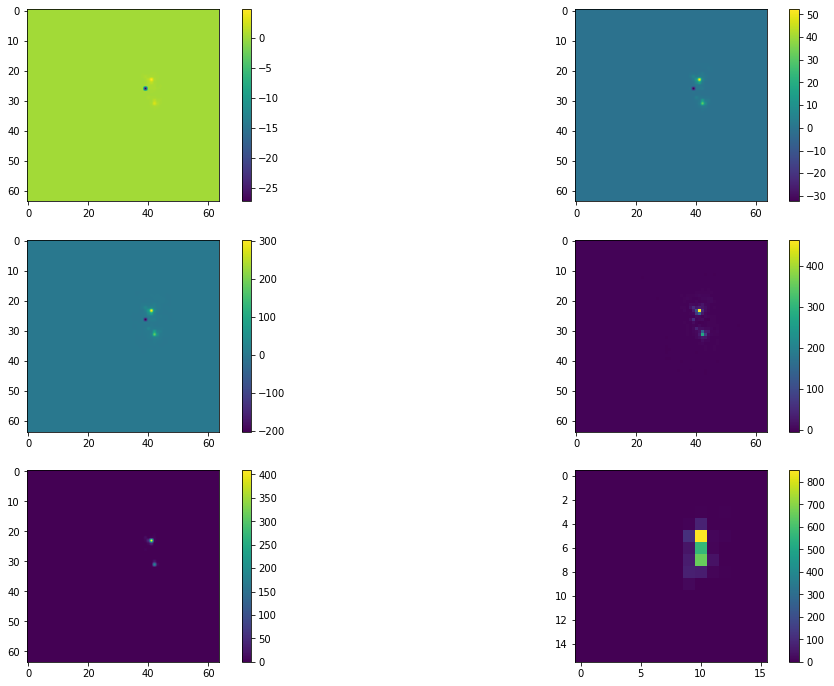

In [65]:
plt.figure(figsize=(18, 12))

plt.subplot(321)
#plt.imshow(input_Layer[22:23][0][1][:16,:16])
plt.imshow(test_out[0][0].detach().numpy())
plt.colorbar()

plt.subplot(322)
plt.imshow(test_out[0][1].detach().numpy())
plt.colorbar()

plt.subplot(323)
plt.imshow(test_out[0][2].detach().numpy())
plt.colorbar()

plt.subplot(324)
plt.imshow(test_out[0][3].detach().numpy())
plt.colorbar()

plt.subplot(325)
plt.imshow(val_Layer[29:30][0][0][:,:])
plt.colorbar()

plt.subplot(326)
plt.imshow(val_Layer[29:30][0][1][:16,:16])
plt.colorbar()